In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tflearn

%matplotlib inline

# read dataset
df_train = pd.read_csv("titanic_training.csv")#("titanic_training.csv")

In [4]:
def preprocess(df):
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
    df['Name'] = df['Name'].str.len()
    return df

In [5]:
df_train = preprocess(df_train)

In [14]:
X = df_train.iloc[:, 0:7] # attributes/inputs
y = df_train['Survived'] # output / needs to be predict

0      1
1      0
2      0
3      1
4      0
      ..
659    0
660    0
661    0
662    1
663    0
Name: Survived, Length: 664, dtype: int64

In [26]:
from tflearn.data_utils import load_csv
data, labels = load_csv("titanic_training.csv", categorical_labels=True,n_classes=2)
labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [27]:
#RP
from sklearn import random_projection

rp = random_projection.GaussianRandomProjection(n_components = 7,random_state = 42) ## 1-7 dimensions
rp_data = rp.fit_transform(X)
rp_data

array([[ 21.34600332, -19.04467192,   1.75297771, ...,  16.52171885,
         -9.84602801,  -7.90795442],
       [ 34.25919591, -27.46025839,   4.3719758 , ...,  28.98004567,
        -17.76109271, -12.85929416],
       [ 41.22478172, -30.18275638,  13.88720241, ...,  37.4080602 ,
        -20.59440391, -11.72987642],
       ...,
       [ 34.63807369, -40.80861447,  17.37859212, ...,  20.00958639,
         -2.3918614 ,  -0.87941428],
       [ 13.43238727, -11.40080692,  -1.0424029 , ...,  10.16152141,
         -7.84052256,  -6.65635344],
       [ 16.70105823, -15.46455653,   3.00946464, ...,  11.63675553,
         -6.89355714,  -5.09423894]])

In [8]:
#Manifold
from sklearn.manifold import Isomap

mf = Isomap(n_components=7,n_neighbors=10)
mf_data = mf.fit_transform(X)
mf_data.shape

(664, 7)

In [21]:
net = tflearn.input_data(shape=[None, 7])
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 32)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net)

In [23]:
model = tflearn.DNN(net)
# Start training (apply gradient descent algorithm)
model.fit(rp_data, labels, n_epoch=15, validation_set=0.2, batch_size=16, show_metric=True)

IndexError: list index out of range

In [ ]:
prediction = model.predict(rp_data)

In [ ]:
# convert predicted data for prediction accuracy comparison
def postprocess(data):
    for i in range(len(data)):
      if data[i][0] > data[i][1]:
          data[i][0] = 1
          data[i][1] = 0
      else:
          data[i][0] = 0
          data[i][1] = 1
    return np.array(data, dtype=np.float32)

In [ ]:
PostPrediction = postprocess(prediction)

In [ ]:
def getSuccessRate(x, y):
    count = 0;
    for i in range(len(x)):
        count += x[i][0] == y[i][0]
    return count

In [ ]:
# compare prediction accuracy with testing sample
success_rate = getSuccessRate(labels_Test, PostPrediction) / len(PostPrediction)
success_rate

In [9]:
# build the KMeans Model
kmeans = KMeans(n_clusters=2,random_state=42, n_init='auto', max_iter=100)
clustersPCA = kmeans.fit_predict(pca_data)
clustersICA = kmeans.fit_predict(ica_data)
clustersRP = kmeans.fit_predict(rp_data)
clustersMF = kmeans.fit_predict(mf_data)

from scipy.stats import mode
labelsPCA = np.zeros_like(clustersPCA)
labelsICA = np.zeros_like(clustersICA)
labelsRP = np.zeros_like(clustersRP)
labelsMF = np.zeros_like(clustersMF)

for i in range(2):
    cat = (clustersPCA == i)
    labelsPCA[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (clustersICA == i)
    labelsICA[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (clustersRP == i)
    labelsRP[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (clustersMF == i)
    labelsMF[cat] = mode(y[cat])[0]

accpca = accuracy_score(y, labelsPCA)
accica = accuracy_score(y, labelsICA)
accrp = accuracy_score(y, labelsRP)
accmf = accuracy_score(y, labelsMF)
print('PCA Accuracy = ', accpca)
print('ICA Accuracy = ', accica)
print('RP Accuracy = ', accrp)
print('MF Accuracy = ', accmf)

PCA Accuracy =  0.6053811659192825
ICA Accuracy =  0.7668161434977578
RP Accuracy =  0.6053811659192825
MF Accuracy =  0.6053811659192825


Text(0, 0.5, 'Age')

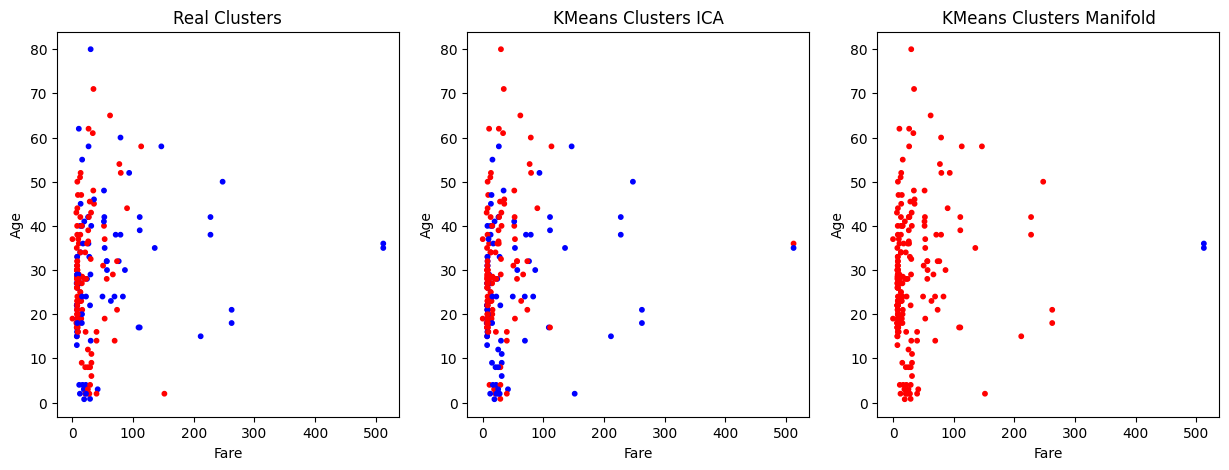

In [15]:
plt.figure(figsize=(15,5))
colormap = np.array(['red', 'blue'])

# Plot the Original Classifications using Petal features
plt.subplot(1, 3, 1)
plt.scatter(X.Fare, X.Age, c = colormap[y], s=10)
plt.title('Real Clusters')
plt.xlabel('Fare')
plt.ylabel('Age')

#plot Kmeans Model Classifications
# plt.subplot(2, 3, 2)
# plt.scatter(X.Fare, X.Age, c = colormap[labelsPCA], s=10)
# plt.title('KMeans Clusters PCA')
# plt.xlabel('Fare')
# plt.ylabel('Age')

plt.subplot(1, 3, 2)
plt.scatter(X.Fare, X.Age, c = colormap[labelsICA], s=10)
plt.title('KMeans Clusters ICA')
plt.xlabel('Fare')
plt.ylabel('Age')

# plt.subplot(2, 3, 4)
# plt.scatter(X.Fare, X.Age, c = colormap[labelsRP], s=10)
# plt.title('KMeans Clusters RP')
# plt.xlabel('Fare')
# plt.ylabel('Age')

plt.subplot(1, 3, 3)
plt.scatter(X.Fare, X.Age, c = colormap[labelsMF], s=10)
plt.title('KMeans Clusters Manifold')
plt.xlabel('Fare')
plt.ylabel('Age')

In [13]:
# General EM for GMM
from sklearn import preprocessing

# transform data so the distribution mean = 0 and std = 1, so preprocessing is needed
scalerPCA = preprocessing.StandardScaler()
scalerPCA.fit(pca_data)
scalerPCA_X = scalerPCA.transform(pca_data)
xsPCA = pd.DataFrame(scalerPCA_X, columns = X.columns)

scalerICA = preprocessing.StandardScaler()
scalerICA.fit(ica_data)
scaledICA_X = scalerICA.transform(ica_data)
xsICA = pd.DataFrame(scaledICA_X, columns = X.columns)


scalerRP = preprocessing.StandardScaler()
scalerRP.fit(rp_data)
scaledRP_X = scalerRP.transform(rp_data)
xsRP = pd.DataFrame(scaledRP_X, columns = X.columns)


scalerMF = preprocessing.StandardScaler()
scalerMF.fit(mf_data)
scaledMF_X = scalerMF.transform(mf_data)
xsMF = pd.DataFrame(scaledMF_X, columns = X.columns)


from sklearn.mixture import GaussianMixture

gmmPCA = GaussianMixture(n_components=2,covariance_type='diag', random_state=42,init_params='k-means++')
gmmPCA_y = gmmPCA.fit_predict(xsPCA)
labelsPCA_gmm = np.zeros_like(clustersPCA)

gmmICA = GaussianMixture(n_components=2,covariance_type='diag', random_state=42,init_params='k-means++')
gmmICA_y = gmmICA.fit_predict(xsICA)
labelsICA_gmm = np.zeros_like(clustersICA)

gmmRP = GaussianMixture(n_components=2,covariance_type='diag', random_state=42,init_params='k-means++')
gmmRP_y = gmmRP.fit_predict(xsRP)
labelsRP_gmm = np.zeros_like(clustersRP)

gmmMF = GaussianMixture(n_components=2,covariance_type='diag', random_state=42,init_params='k-means++')
gmmMF_y = gmmMF.fit_predict(xsMF)
labelsMF_gmm = np.zeros_like(clustersMF)

for i in range(2):
    cat = (gmmPCA_y == i)
    labelsPCA_gmm[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (gmmICA_y == i)
    labelsICA_gmm[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (gmmRP_y == i)
    labelsRP_gmm[cat] = mode(y[cat])[0]

for i in range(2):
    cat = (gmmMF_y == i)
    labelsMF_gmm[cat] = mode(y[cat])[0]

accPCA_gmm = accuracy_score(y, labelsPCA_gmm)
accICA_gmm = accuracy_score(y, labelsICA_gmm)
accRP_gmm = accuracy_score(y, labelsRP_gmm)
accMF_gmm = accuracy_score(y, labelsMF_gmm)

print('PCA Accuracy using GMM = ', accPCA_gmm)
print('ICA Accuracy using GMM = ', accICA_gmm)
print('RP Accuracy using GMM = ', accRP_gmm)
print('MF Accuracy using GMM = ', accMF_gmm)

PCA Accuracy using GMM =  0.6681614349775785
ICA Accuracy using GMM =  0.7668161434977578
RP Accuracy using GMM =  0.6636771300448431
MF Accuracy using GMM =  0.6412556053811659


Text(0, 0.5, 'Age')

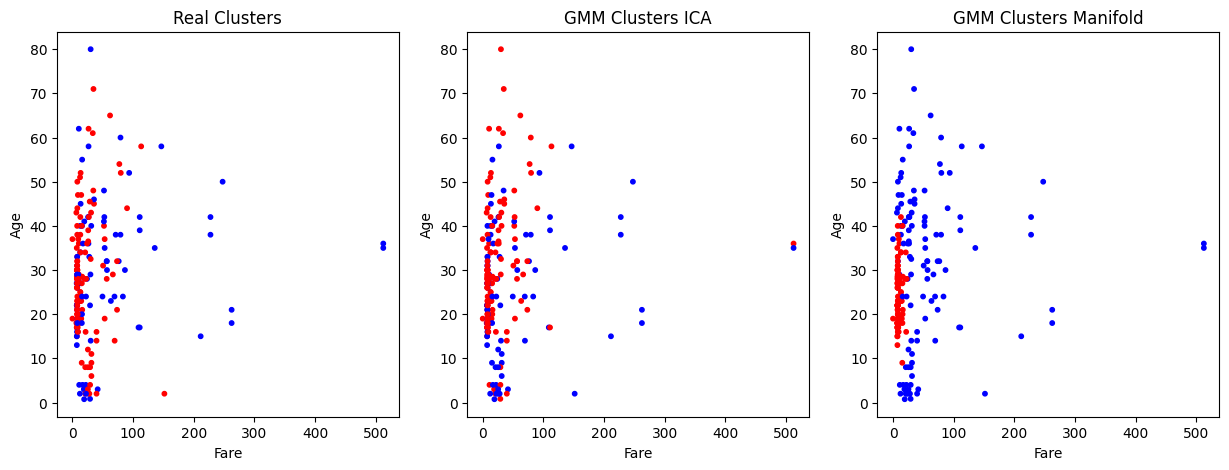

In [16]:
plt.figure(figsize=(15,5))
colormap = np.array(['red', 'blue'])

# Plot the Original Classifications using Petal features
plt.subplot(1, 3, 1)
plt.scatter(X.Fare, X.Age, c = colormap[y], s=10)
plt.title('Real Clusters')
plt.xlabel('Fare')
plt.ylabel('Age')

#plot Kmeans Model Classifications
# plt.subplot(2, 3, 2)
# plt.scatter(X.Fare, X.Age, c = colormap[labelsPCA_gmm], s=10)
# plt.title('GMM Clusters PCA')
# plt.xlabel('Fare')
# plt.ylabel('Age')

plt.subplot(1, 3, 2)
plt.scatter(X.Fare, X.Age, c = colormap[labelsICA_gmm], s=10)
plt.title('GMM Clusters ICA')
plt.xlabel('Fare')
plt.ylabel('Age')

# plt.subplot(2, 3, 4)
# plt.scatter(X.Fare, X.Age, c = colormap[labelsRP_gmm], s=10)
# plt.title('GMM Clusters RP')
# plt.xlabel('Fare')
# plt.ylabel('Age')

plt.subplot(1, 3, 3)
plt.scatter(X.Fare, X.Age, c = colormap[labelsMF_gmm], s=10)
plt.title('GMM Clusters Manifold')
plt.xlabel('Fare')
plt.ylabel('Age')